In [2]:
# For this notebook, we've picked an instance of maxcut. Other problems are more interesting,
# but this is the one always used in the literature.

# The goal here is to setup a Maxcut QAOA instance using qiskit, and execute it on the qiskit simulator
# using the ColdQuanta API. To validate our results, we will look for the canonical ``qaoa landscape" and 
# see that it loses contrast when the noise is increased.

In [32]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
# Set up a 2x2 grid topology.
rows = cols = 2
neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map

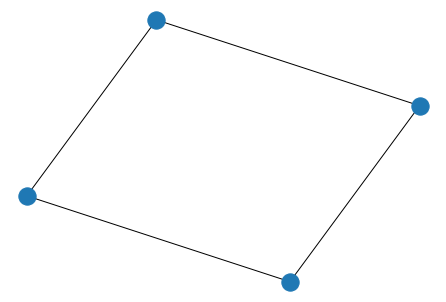

In [33]:
from networkx import Graph, draw_spring
g = Graph(coupling_map)
# Plot with the Fruchterman-Reingold force-directed algorithm.
draw_spring(g)

In [34]:
# We will currently only accept QAOA instances on graphs isomorphic to our own -
# i.e. we are not implementing a compiler. Provide them as a dictionary.

# Uniform weights.
weights = {tuple(k): 1 for k in coupling_map}

In [52]:
# It looks like Qiskit hasn't implemented any kind of exponentiation - 
# in particular, they write to use "an Ising-type gate":
# https://qiskit.org/textbook/ch-applications/qaoa.html#2.1-(weighted)-$MAXCUT$
# Rigetti has implemented an exponentiate-like feature -
# http://docs.rigetti.com/en/stable/apidocs/autogen/pyquil.paulis.exponentiate.html#pyquil.paulis.exponentiate

# For this example, everything is diagonal and we are free to just compute the QAOA circuit from the weights.
# Taking from the qiskit tutorial:
from qiskit import QuantumCircuit
QAOA = QuantumCircuit(rows*cols, rows*cols) #qubits, classical bits

def qaoa_circuit(gamma, beta):
    # apply the layer of Hadamard gates to all qubits, and then fence all qubits.
    QAOA.h(range(rows*cols))
    QAOA.barrier()

    # apply the Ising type gates with angle gamma along the edges in E
    for edge, weight in weights.items():
        k = edge[0]
        l = edge[1]
        # The following is a gate decomposition for a exp(-i*\gamma*ZZ). **UNVERIFIED**.
        # Controlled-U1 gate - i.e. Controlled phase.
        QAOA.cu1(-2*gamma*weight, k, l)
        QAOA.u1(gamma, k)
        QAOA.u1(gamma, l)

    # then apply the single qubit X - rotations with angle beta to all qubits
    QAOA.barrier()
    #\exp^{-i\beta\sigma_x} = RX(2*\beta), so the factor of two keeps us consistent with https://arxiv.org/pdf/1411.4028 
    QAOA.rx(-2*beta, range(rows*cols))
    return QAOA